# Importing the Libraries

In [0]:
!pip install tensorboardcolab

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import pickle
import random
import tensorflow as tf
from skimage.io import imread, imshow, imread_collection, concatenate_images


# Preprocessing 
- Loading images into arrays
- storing the arrays into pickle file

## DO NOT RUN THE CELLS UPTILL CNN MODEL

In [0]:
image_height = 128
image_width = 128

In [0]:
train_data_file = pd.read_csv('/content/gdrive/My Drive/training_set.csv')
train_data_file.head()


,image_name,x1,x2,y1,y2
0,JPEG_20160517_140621_1000651031832.png,78,446,83,422
1,1473231510890DeeplearnS11456.png,73,567,146,351
2,1476881557883Untitled1.png,13,561,124,362
3,1474264827890cobalt-beyond-the-sea-maxi-dress3...,0,640,140,330
4,JPEG_20160711_113321_1000235741992.png,217,442,65,465


In [0]:
print(len(train_data_file))

24000


In [0]:
with open("/content/gdrive/My Drive/training_images_2.pkl","rb") as file:
    images_array = pickle.load(file)
images_array = np.array(images_array)
print(images_array[0])
print("size of pickle array : {}".format(len(images_array)))

[[[125 140 143]
  [125 140 142]
  [123 138 140]
  ...
  [ 75  85  85]
  [ 76  85  85]
  [ 75  86  84]]

 [[127 142 145]
  [125 140 143]
  [124 139 141]
  ...
  [ 75  87  87]
  [ 76  85  88]
  [ 76  86  86]]

 [[130 145 148]
  [128 143 146]
  [127 142 145]
  ...
  [ 76  88  90]
  [ 76  85  89]
  [ 78  87  90]]

 ...

 [[121 140 143]
  [125 144 147]
  [124 143 148]
  ...
  [ 72  87  72]
  [ 64  68  18]
  [ 54  52   0]]

 [[119 138 141]
  [120 139 142]
  [121 140 145]
  ...
  [ 57  66  34]
  [ 59  61   2]
  [ 57  60  10]]

 [[118 135 138]
  [118 135 138]
  [121 138 141]
  ...
  [ 57  65  28]
  [ 62  65   9]
  [ 57  63  11]]]
size of pickle array : 24000


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


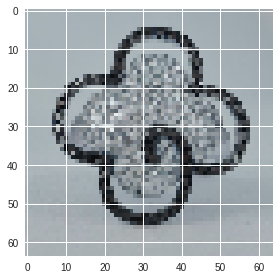

In [0]:
ix = random.randint(0, len(images_array))
imshow(images_array[ix])
plt.show()


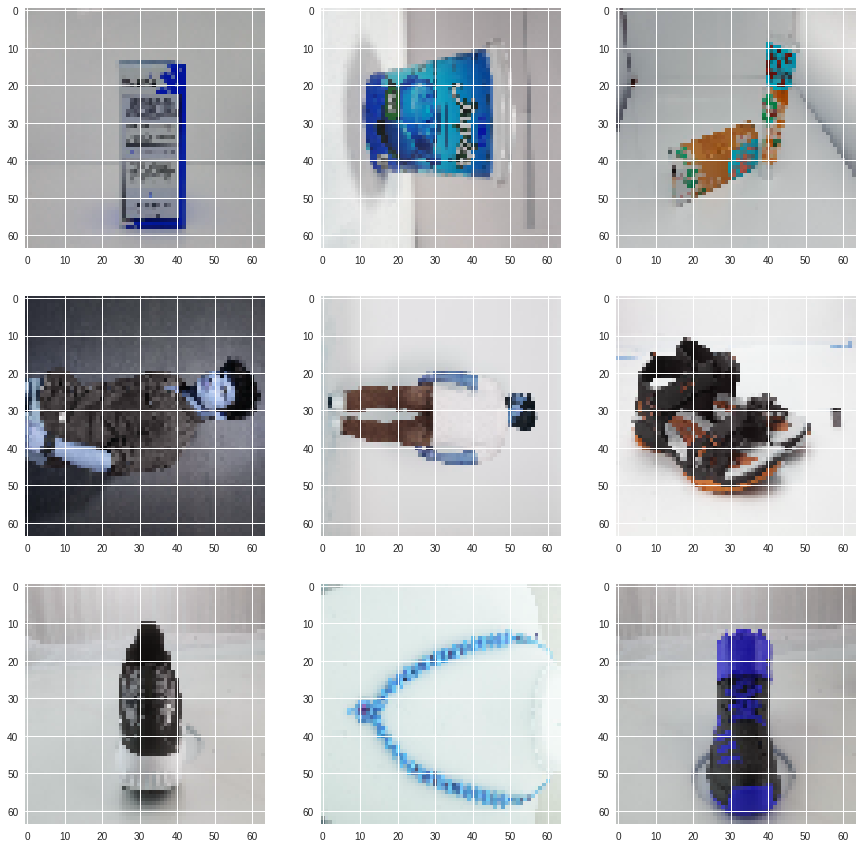

In [0]:
fig = plt.subplots(3,3,sharex='col',sharey='row',figsize=(15,15))
plt.xticks([])
plt.yticks([])
plt.axis("off")

for i in range(1,10):
  rand_index = random.randint(0,len(images_array))
  plt.subplot(3,3,i)
  plt.imshow(images_array[rand_index])
plt.show()

# Unet  Model Implementation
- run the cells below this

In [0]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input,GlobalAveragePooling2D,Dense
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [0]:
def IOU_calc(y_true, y_pred,smooth=2):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [0]:
inputs = Input((image_height, image_width, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)

c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

gap_layer = GlobalAveragePooling2D() (c9)
outputs = Dense(4,activation='linear')(gap_layer)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='mse', metrics=[IOU_calc_loss])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 128, 128, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_92 (Conv2D)              (None, 128, 128, 16) 448         lambda_6[0][0]                   
__________________________________________________________________________________________________
dropout_46 (Dropout)            (None, 128, 128, 16) 0           conv2d_92[0][0]                  
__________________________________________________________________________________________________
conv2d_93 

In [0]:
earlystopper = EarlyStopping(patience=5, verbose=1)


# Preparing the Input Data

In [0]:
images_array = images_array.astype(np.float32)
print(images_array.dtype)


float32


In [0]:
output_label = train_data_file.iloc[:,1:]
output_label = output_label.values
print(images_array.shape,output_label.shape)

(24000, 64, 64, 3) (24000, 4)


In [0]:
output_label[:,0] = output_label[:,0]*128 / 640
output_label[:,1] = output_label[:,1]*128 / 640
output_label[:,2] = output_label[:,2]*128 / 480
output_label[:,3] = output_label[:,3]*128 / 480

In [0]:
print(output_label)

[[ 15  89  22 112]
 [ 14 113  38  93]
 [  2 112  33  96]
 ...
 [ 24 118   8 120]
 [  8 114  27 109]
 [ 14 106  43  90]]


# Train the model

In [0]:
results = model.fit(images_array, output_label, validation_split=0.1, batch_size=16, epochs=5, 
                    callbacks=[earlystopper])

NameError: ignored

In [0]:
! pip install keras-vis


In [0]:
from vis.visualization import visualize_cam
layer_idx = model.layers[-6]
seed_input = images_array[0]
visualize_cam(model, layer_idx,seed_input)

TypeError: ignored

In [0]:
import pickle
import numpy as np
with open("/content/gdrive/My Drive/Colab Notebooks/image_arr2.pkl","rb") as file:
    test_images = pickle.load(file)
test_image = np.array(test_images)

In [0]:
test_image = test_image.astype("float32")


NameError: ignored

In [0]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/detector_1st-corr.h5')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
pred_values = detector.predict(test_image)

In [0]:
print(pred_values)

[[ 35.236393 592.3403    52.81777  424.21793 ]
 [ 64.88444  572.24146   57.038708 409.58655 ]
 [ 92.01625  537.31134   63.60853  387.74478 ]
 ...
 [ 32.00356  608.0943    69.49086  416.63058 ]
 [ 41.588844 559.607     62.559326 397.46445 ]
 [ 27.997965 610.6651    42.71215  430.5142  ]]


In [0]:
pred_values[:,0] = pred_values[:,0]*640 /128
pred_values[:,1] = pred_values[:,1]*640 /128
pred_values[:,2] = pred_values[:,2]*480 /128
pred_values[:,3] = pred_values[:,3]*480 /128

In [0]:
for i in range(len(pred_values)) : 
  pred_values[i][0],pred_values[i][1],pred_values[i][2],pred_values[i][3] = int(pred_values[i][0]),int(pred_values[i][1]),int(pred_values[i][2]),int(pred_values[i][3])

In [0]:
print(pred_values)

[[ 35. 592.  52. 424.]
 [ 64. 572.  57. 409.]
 [ 92. 537.  63. 387.]
 ...
 [ 32. 608.  69. 416.]
 [ 41. 559.  62. 397.]
 [ 27. 610.  42. 430.]]


In [0]:
import pandas as pd
test_file = pd.read_csv("/content/gdrive/My Drive/test_new.csv")

In [0]:
print(len(pred_values))

24045


In [0]:
test_file['x1'] = pred_values[:,0]
test_file['x2'] = pred_values[:,1]
test_file['y1'] = pred_values[:,2]
test_file['y2'] = pred_values[:,3]


In [0]:
test_file['x1'] = test_file['x1'].apply(lambda row: 0 if row<=0 else row)
test_file['x2'] = test_file['x2'].apply(lambda row: 640 if row>=640 else row)
test_file['y1'] = test_file['y1'].apply(lambda row: 0 if row<=0 else row)
test_file['y2'] = test_file['y2'].apply(lambda row: 480 if row>=480 else row)

In [0]:
test_file.to_csv('/content/gdrive/My Drive/Colab Notebooks/test_level2.csv')